#### **Normalizing Flow Test cases:**
- Tutorial mentioned in email: 
  - http://akosiorek.github.io/ml/2018/04/03/norm_flows.html
- Ritchie Vink's blog: (A lot of inspirations and experiments) 
  - https://www.ritchievink.com/blog/2019/11/12/another-normalizing-flow-inverse-autoregressive-flows/

In [0]:
!pip install pyro-ppl

- Normalizing flow (Planar flow): https://www.ritchievink.com/blog/2019/10/11/sculpting-distributions-with-normalizing-flows/

In [0]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from scipy import stats
import torch.nn as nn
from torch import distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [0]:
# implement some other improvements related to normalizing flow in PyTorch
# Planar flows
# define Planar class
class Planar(nn.Module):
    def __init__(self, size=1, init_sigma=0.01):
        super().__init__()
        # f(z) = z + uh(w^Tz + b) - initialized parameters for Planar Flow
        self.u = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.w = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.b = nn.Parameter(torch.zeros(1))

    @property
    def normalized_u(self):
        # Needed for invertibility condition.
        # See Appendix A.1
        # Rezende et al. Variational Inference with Normalizing Flows
        # https://arxiv.org/pdf/1505.05770.pdf
        # softplus
        def m(x):
            return -1 + torch.log(1 + torch.exp(x))
        wtu = torch.matmul(self.w, self.u.t())
        w_div_w2 = self.w / torch.norm(self.w)
        return self.u + (m(wtu) - wtu) * w_div_w2
    def psi(self, z):
        # ψ(z) =h′(w^tz+b)w -See eq(11)
        # Rezende et al. Variational Inference with Normalizing Flows
        # https://arxiv.org/pdf/1505.05770.pdf
        return self.h_prime(z @ self.w.t() + self.b) @ self.w

    # The function h() needs to be a smooth non-linear function (tanh() maybe)
    def h(self, x):
        return torch.tanh(x)
    def h_prime(self, z):
        return 1 - torch.tanh(z) ** 2
        
    # do transformation and log(abs(det)) for single flow
    def forward(self, z):
        if isinstance(z, tuple):
            z, accumulating_ldj = z
        else:
            z, accumulating_ldj = z, 0
        psi = self.psi(z)
        u = self.normalized_u
        # determinant of jacobian
        det = (1 + psi @ u.t())
        # log |det Jac|
        ldj = torch.log(torch.abs(det) + 1e-6)
        # # f(z) = z + uh(w^Tz + b)
        wzb = z @ self.w.t() + self.b
        fz = z + (u * self.h(wzb))
        return fz, ldj + accumulating_ldj

In [10]:
print(nn.Parameter(torch.randn(5, ).normal_(1, 0.01)))

Parameter containing:
tensor([0.9983, 0.9848, 1.0038, 0.9897, 0.9944], requires_grad=True)


In [0]:
class Flow(nn.Module):
    def __init__(self, dim=2, n_flows=10):
        super().__init__()
        self.flow = nn.Sequential(*[Planar(dim) for _ in range(n_flows)])
        self.mu = nn.Parameter(torch.randn(dim, ).normal_(0, 0.01))
        self.log_var = nn.Parameter(torch.randn(dim, ).normal_(1, 0.01))
    def forward(self, shape):
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn(shape)  # unit gaussian
        # Each layer of latent variables is dependent on the layer above in a non-linear way
        # the Lth Gaussian distribution is not dependent on any other random variables. 
        # The prior over latent variables is a unit Gaussian p(z)=N(0,I)
        z0 = self.mu + eps * std
        zk, ldj = self.flow(z0)
        return z0, zk, ldj, self.mu, self.log_var

In [0]:
def target_density(z):
    z1, z2 = z[..., 0], z[..., 1]
    norm = (z1**2 + z2**2)**0.5
    exp1 = torch.exp(-0.2 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.2 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

def det_loss(mu, log_var, z_0, z_k, ldj, beta):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    batch_size = z_0.size(0)
    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    # P(x|z)
    nll = -torch.log(target_density(z_k) + 1e-7).sum() * beta
    return (log_qzk + nll) / batch_size

def train_flow(flow, shape, epochs=1000):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)
    for i in range(epochs):
        z0, zk, ldj, mu, log_var = flow(shape=shape)
        loss = det_loss(mu=mu, log_var=log_var, z_0=z0, z_k=zk, ldj=ldj, beta=1)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if i % 200 == 0:
            print(loss.item())

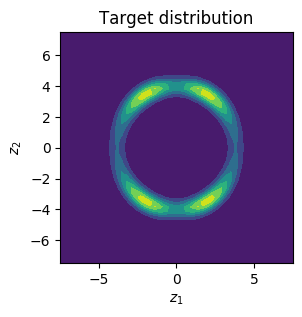

In [6]:
x1 = np.linspace(-7.5, 7.5)
x2 = np.linspace(-7.5, 7.5)
x1_s, x2_s = np.meshgrid(x1, x2)
x_field = np.concatenate([x1_s[..., None], x2_s[..., None]], axis=-1)
x_field = torch.tensor(x_field, dtype=torch.float)

plt.figure(figsize=(3, 3))
plt.title("Target distribution")
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.contourf(x1_s, x2_s, target_density(x_field))
plt.show()

In [0]:
def show_samples(s):
  plt.figure(figsize=(3, 3))
  plt.scatter(s[:, 0], s[:, 1], alpha=0.1)
  plt.show()

In [11]:
flow = Flow(dim=2, n_flows=10)
shape = (1000, 2)
train_flow(flow, shape, epochs=5000)
z0, zk, ldj, mu, log_var = flow((5000, 2))

6.92289924621582
-1.4125239849090576
-1.7216870784759521
-1.8565168380737305
-2.08664870262146
-2.1896309852600098
-2.3531808853149414
-2.4720332622528076
-2.580113410949707
-2.578324794769287
-2.615509033203125
-2.6315841674804688
-2.639942169189453
-2.6703219413757324
-2.65594220161438
-2.6710424423217773
-2.636899948120117
-2.6876792907714844
-2.6913931369781494
-2.657528877258301
-2.6324076652526855
-2.6214118003845215
-2.6641907691955566
-2.67655348777771
-2.6689515113830566


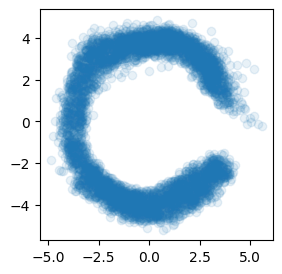

In [12]:
show_samples(zk.data)

#### **Test with Pyro**
- Official Tutorial Conditional Transform Planar in Pyro: https://pyro4ci.readthedocs.io/en/latest/_modules/pyro/distributions/transforms/planar.html
- Blog: https://bmazoure.github.io/posts/nf-in-pyro/
- Mathematical: (Flow-based deep generative models) https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html

In [0]:
from pyro.nn import AutoRegressiveNN
from pyro import distributions
import pyro, torch
import numpy as np
import matplotlib.pyplot as plt
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO, TraceGraph_ELBO
%matplotlib inline

from torch.distributions.multivariate_normal import MultivariateNormal as mvn
import seaborn as sns
import torch.nn as nn
from torch import distributions as dist

torch.manual_seed(0)
np.random.seed(0)

#### **Radial Flow, SylvesterFlow and PlanarFlow:**

In [14]:
import pyro.distributions.transforms.radial as Radial
import pyro.distributions.transforms.sylvester as Sylvester
import pyro.distributions.transforms.planar as Planar
# RadialFlow
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
transform = Radial(1)
pyro.module("my_transform", transform)  # doctest: +SKIP
flow_dist = dist.TransformedDistribution(base_dist, [transform])
flow_dist.sample()  # doctest: +SKIP

tensor([0.5589])

In [15]:
# PlanarFlow
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
transform = Planar(1)
pyro.module("my_transform", transform)  # doctest: +SKIP
flow_dist = dist.TransformedDistribution(base_dist, [transform])
flow_dist.sample()  # doctest: +SKIP

tensor([0.0887])

In [16]:
# SylvesterFlow
# Here needs another parameter count_transforms other than input dimension
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
transform = Sylvester(1, count_transforms=1)
pyro.module("my_transform", transform)  # doctest: +SKIP
flow_dist = dist.TransformedDistribution(base_dist, [transform])
flow_dist.sample()  # doctest: +SKIP

tensor([0.6035])

In [9]:
import pyro.distributions.transforms.householder as Householder
# HouseholderFlow
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
flow = Householder(1, count_transforms=1)
pyro.module("my_flow", flow) # doctest: +SKIP
flow_dist = dist.TransformedDistribution(base_dist, flow)
flow_dist.sample()  # doctest: +SKIP

tensor([-0.2072])

In [42]:
import pyro.distributions.transforms.affine_autoregressive as AffineAutoregressive
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
transform = AffineAutoregressive(2)
pyro.module("my_transform", transform)  # doctest: +SKIP
flow_dist = dist.TransformedDistribution(base_dist, [transform])
flow_dist.sample()  # doctest: +SKIP

tensor([-2.0064, -1.1276])

In [19]:
# some pre-test
# lambda function
base_dist=lambda dim:distributions.Normal(torch.zeros(dim), torch.ones(dim))
print(base_dist(2))
print(np.random.randint(low=0,high=10000,size=1)[0])

Normal(loc: torch.Size([2]), scale: torch.Size([2]))
2732


In [0]:
# Model: p(x,z) has to be from torch.distributions or extended by Pyro transforms
# Guide: q(z|x) the variational approximation to the true posterior. This is the NF.

# The below class simply allows to combine multiple NF layers (of the same kind/hyperparameters). 
# However, it would be possible to mix, say, affine layers with radial and followed by IAF.
class NormalizingFlow(nn.Module):
  # RadialFlow: 
  def __init__(self, dim, n_flows, base_dist, flow_type):
    super(NormalizingFlow, self).__init__()
    self.dim = dim
    self.n_flows = n_flows
    self.base_dist = base_dist
    self.uuid = np.random.randint(low=0,high=10000,size=1)[0]

    # Initialize all flows
    # shared dimentions for all layers in normalizing flows
    self.nfs = []
    for f in range(n_flows):
      nf = flow_type
      self.nfs.append(nf)
    # This step assumes that nfs={f_i}_{i=1}^N and that base_dist=N(0,I)
    # Then register the (biejctive) transformation Z=nfs(eps), eps~base_dist
    # class TransformedDistribution(base_distribution, transforms, validate_args=None)
    self.nf_dist = distributions.TransformedDistribution(self.base_dist, self.nfs)
    self._register()

  def _register(self):
    # Register all N flows with Pyro
    for f in range(self.n_flows):
      nf_module = pyro.module("%d_nf_%d" %(self.uuid,f), self.nfs[f])

  def target(self, x, p_qz):
    # p(x,z), but x is not required if there is a true density function (p_z in this case)
    # 1. Sample Z ~ p_z
    # 2. Score it's likelihood against p_z
    with pyro.plate("data", x.shape[0]):
      p = p_z()
      z = pyro.sample("latent",p)
      pyro.sample("obs", p, obs=x.reshape(-1, self.dim))
  
  def model(self,x,p_z):
      # q(z|x) once again x is not required
      # 1. Sample Z ~ nfs(eps), eps ~ N(0,I)
      # This is the NN being trained
      self._register()
      with pyro.plate("data", x.shape[0]):
        pyro.sample("latent", self.nf_dist)

  def sample(self,n):
      # Sample a batch of (n,dim)  
      # Bug: in IAF and IAFStable, the dimensions throw an error (todo)
      return self.nf_dist.sample(torch.Size([n]))

  def log_prob(self,z):
      return self.nf_dist.log_prob(z)

In [0]:
# There are some flows missing available inverse functions
# https://pyro4ci.readthedocs.io/en/latest/distributions.html

base_dist = lambda dim:distributions.Normal(torch.zeros(dim), torch.ones(dim))
# flow = lambda dim:distributions.transforms.radial(dim)
# flow = lambda dim:distributions.transforms.householder(dim, count_transforms=dim)
# flow = lambda dim:distributions.transforms.affine_autoregressive(dim)
flow = lambda dim:Householder(dim, count_transforms=dim)
dim = 2
n_flows = 5
nf_obj = NormalizingFlow(dim=dim, n_flows=n_flows, base_dist=base_dist(dim), flow_type=flow(dim))

In [23]:
# return a batch of (n,dim)
print(nf_obj.sample(5))
print(nf_obj.sample(5).shape)

tensor([[-0.2445,  0.6006],
        [ 1.6749,  0.4683],
        [-1.1221,  0.6400],
        [ 0.0274, -0.0905],
        [-0.8327, -0.9966]])
torch.Size([5, 2])


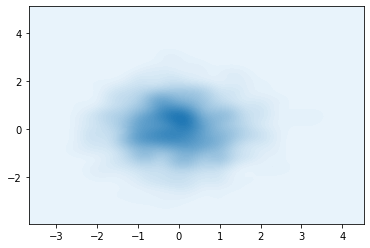

In [24]:
# We can sample eps from N(0,I) and then pass it through an untrained NF to visualize the output.
samples = nf_obj.sample(1000).numpy()
sns.kdeplot(data=samples[:,0],data2=samples[:,1],n_levels=60, shade=True)
plt.show()

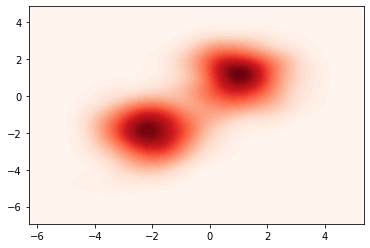

In [25]:
def p_z(mu1=torch.FloatTensor([1,1]),
        mu2=torch.FloatTensor([-2,-2]),
        Sigma1 = torch.FloatTensor([1,1]),
        Sigma2 = torch.FloatTensor([1,1]),
        component_logits = torch.FloatTensor([0.5,0.5]) # mixture weights
       ):
    dist = distributions.MixtureOfDiagNormals(locs=torch.stack([mu1,mu2],axis=0),
                                       coord_scale=torch.stack([Sigma1,Sigma2],axis=0),
                                       component_logits=component_logits)
    return dist

samples = p_z().sample(torch.Size([1000])).numpy()
sns.kdeplot(data=samples[:,0],data2=samples[:,1],n_levels=60, shade=True,cmap="Reds")
plt.show()

In [26]:
# https://github.com/pyro-ppl/pyro/issues/2076
# there is a bug when composing a transform with an analytic inverse to one without.
# The inverse of Tanh is calculated analytically, which then differs (in reference) from the value stored in the cache of the Sylvester transform.

adam_params = {"lr": 0.2, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(nf_obj.target, nf_obj.model, optimizer, loss=Trace_ELBO())
n_steps = 5000 # number of batches
dist = p_z() # true distribution
# do gradient steps
losses = []
for step in range(n_steps):
    data = dist.rsample(torch.Size([128])) # using a batch of 128 new data points every step
    loss = svi.step(data, p_z) # analogous to opt.step() in PyTorch
    losses.append(loss)
    if step % 500 == 0:
        print(loss)

562.6680603027344
583.379638671875
572.3600463867188
576.3845520019531
585.1875305175781
584.5341186523438
559.7158813476562
567.4950561523438
554.5603332519531
565.0013122558594


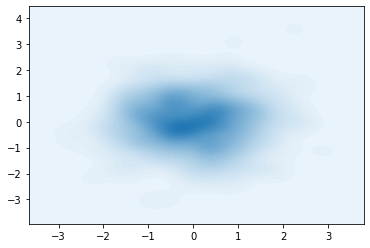

<Figure size 216x216 with 0 Axes>

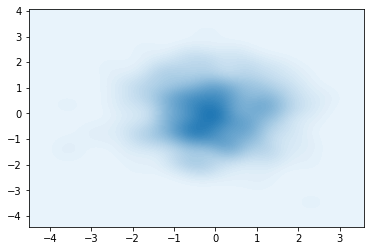

<Figure size 216x216 with 0 Axes>

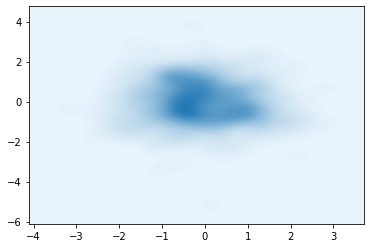

<Figure size 216x216 with 0 Axes>

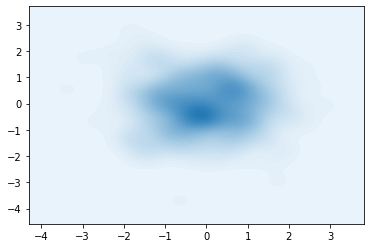

<Figure size 216x216 with 0 Axes>

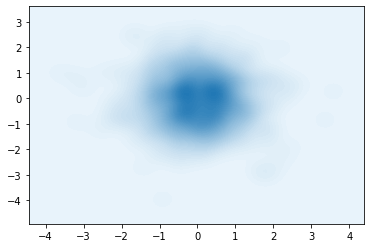

<Figure size 216x216 with 0 Axes>

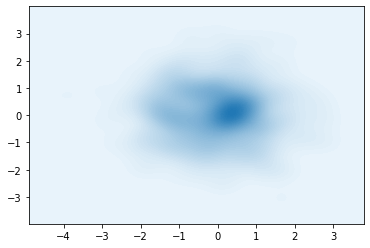

<Figure size 216x216 with 0 Axes>

In [27]:
# observe tranformed flows 
for f in range(n_flows+1):
    intermediate_nf = distributions.TransformedDistribution(nf_obj.base_dist, nf_obj.nfs[:f])
    samples = intermediate_nf.sample(torch.Size([500])).numpy()
    sns.kdeplot(data=samples[:,0],data2=samples[:,1],n_levels=60, shade=True)
    plt.figure(figsize=(3, 3))
    plt.show()

In [28]:
# check parameters within flows if possible
# the storage of parameters in Normalizing flows is exactly the same 
for key, value in pyro.get_param_store().items():    
    print(f"{key}:\n{value}\n")

my_transform$$$x0:
Parameter containing:
tensor([-0.8230], requires_grad=True)

my_transform$$$alpha_prime:
Parameter containing:
tensor([-0.0075], requires_grad=True)

my_transform$$$beta_prime:
Parameter containing:
tensor([0.5364], requires_grad=True)

my_transform$$$bias:
Parameter containing:
tensor([0.], requires_grad=True)

my_transform$$$u:
Parameter containing:
tensor([-0.0887], requires_grad=True)

my_transform$$$w:
Parameter containing:
tensor([0.7929], requires_grad=True)

my_transform$$$u_unnormed:
Parameter containing:
tensor([[0.2646]], requires_grad=True)

my_transform$$$R_dense:
Parameter containing:
tensor([[-0.0066]], requires_grad=True)

my_transform$$$S_dense:
Parameter containing:
tensor([[-0.0041]], requires_grad=True)

my_transform$$$R_diag:
Parameter containing:
tensor([-0.0020], requires_grad=True)

my_transform$$$S_diag:
Parameter containing:
tensor([-0.0096], requires_grad=True)

my_transform$$$b:
Parameter containing:
tensor([-0.0030], requires_grad=True)



#### **Now Try to combine this Flows with Previous BCCA**


In [0]:
import numpy as np
import math
from scipy.stats import ortho_group

# We use the pyro.generic interface to support dynamic choice of backend.
from pyro.generic import pyro_backend
from pyro.generic import distributions as dist
from pyro.generic import infer, optim, pyro

import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
# arguments used to instantiate PyTorch optimizers for all the parameters
from pyro.optim import Adam
# Prediction
from pyro.infer import Predictive

import torch
import pyro
import pyro.optim
import pyro.infer
import pyro.contrib.autoguide as autoguide
import numpy as np
import time as tm

from pyro.poutine import trace
from pprint import pprint
from torch.distributions import constraints

In [0]:
# data generation
N = 100 # sample size in each fake dataset
D = [6, 8] # columns size for two datasets
K = 10 # no. of latent dimensions prior(actual K is unknown in model)
K_est = 10 # of shared LF to be estimated (actual K is unknown in model)
J = [4, 2] # unshared latent factors dimensions
eps = 0.1 # non-CCA iid error scale

In [53]:
## shared/common factors ##
Z_shared = np.zeros((K, N))
# update by row 
Z_shared[0,] = np.sin(np.array([i for i in range(1, N+1)])/N/20)
Z_shared[1,] = np.cos(np.array([i for i in range(1, N+1)])/N/20)
Z_shared[2,] = np.random.normal(0, 1, N)
Z_shared[3,] = 2*np.array([i for i in range(1, N+1)])/N - 0.5

m = ortho_group.rvs(dim=J[0]) # orthonormal matrix
Sig_1 = np.matmul(np.matmul(m, np.diag(10*np.random.random(J[0]))), np.transpose(m))
n = ortho_group.rvs(dim=J[1])
Sig_2 = np.matmul(np.matmul(n, np.diag(10*np.random.random(J[1]))), np.transpose(n))

# generate unshared factors
Z_1 = np.transpose(np.random.multivariate_normal([0]*J[0], Sig_1, N))
Z_2 = np.transpose(np.random.multivariate_normal([0]*J[1], Sig_2, N))

A_1 = np.random.randint(-10, 10, size=(D[0], K))
A_2 = np.random.randint(-10, 10, size=(D[1], K)) + 0.5
# generate weight matrix for Z unshared
B_1 = np.random.randint(-10, 0, size=(D[0], J[0]))/10
B_2 = np.random.randint(0, 10, size=(D[1], J[1]))/10

X_1 = np.transpose(np.random.normal(0, eps, D[0]*N).reshape((D[0], N)) + np.matmul(A_1, Z_shared) + np.matmul(B_1, Z_1))
X_2 = np.transpose(np.random.normal(0, eps, D[1]*N).reshape((D[1], N)) + np.matmul(A_2, Z_shared) + np.matmul(B_2, Z_2))
data = np.concatenate((X_1, X_2), axis=1)

data = torch.tensor(data)
data = data.transpose_(0, 1)
N = data.shape[1] # no. of observations
print(N)

100


In [0]:
# Combination of BCCA and Affine Autoregressive Flows Module
class BCCA_AffineAutoregressive(nn.Module):
  def __init__(self, n_flows, base_dist, flow_type, z_dim=N):
    super(BCCA_AffineAutoregressive, self).__init__()
    self.z_dim = z_dim
    self.n_flows = n_flows
    self.base_dist = base_dist
    self.uuid = np.random.randint(low=0,high=10000,size=1)[0]

    # Initialize all flows
    # shared dimentions for all layers in normalizing fl
    self.nfs = []
    for f in range(n_flows):
      nf = flow_type
      self.nfs.append(nf)
    self.nf_dist = distributions.TransformedDistribution(self.base_dist, self.nfs)
    self._register()

  def _register(self):
    # Register all N flows with Pyro
    for f in range(self.n_flows):
      nf_module = pyro.module("%d_nf_%d" %(self.uuid,f), self.nfs[f])
  
  # sampling and log_prob calculation
  def sample(self,n):
      # Sample a batch of (n,dim)  
      return self.nf_dist.sample(torch.Size([n]))
  def log_prob(self,z):
      # log_prob = [self.nf_dist.log_prob(z[i]) for i in range(z.shape[0])]
      return self.nf_dist.log_prob(z)
      # return sum(log_prob)

  # Now define model and guide function
  def model(self, data):
    # data here may not be required 
    tau = pyro.sample('tau', dist.Gamma(torch.tensor(0.1), torch.tensor(0.1)).expand([K, 2]).independent(2))  
    sig = pyro.sample('sig', dist.Gamma(torch.tensor(0.1), torch.tensor(0.1)).expand([2]).independent(1)) 
    Z = pyro.sample("Z", dist.Normal(0.0, 1.0).expand([K, self.z_dim]).independent(2))
    # weight matrix
    W1 = pyro.sample("W1", dist.Normal(torch.tensor(0.0), tau[:, 0].sqrt().reciprocal()).expand_by([D[0]]).independent(2)) # D[0]*K
    W2 = pyro.sample("W2", dist.Normal(torch.tensor(0.0), tau[:, 1].sqrt().reciprocal()).expand_by([D[1]]).independent(2)) # D[1]*K
    # dataset sampling
    pyro.sample("dataset_1", dist.Normal(torch.mm(W1, Z), sig[0]).independent(2), obs=data[:D[0], :])
    pyro.sample("dataset_2", dist.Normal(torch.mm(W2, Z), sig[1]).independent(2), obs=data[D[0]:, :])

  def guide_flexible(self, data):
    # again data here may not be required 
    # Sample Z from Normalizing flows
    # This is the NN being trained
    self._register()
    valid_range = constraints.greater_than(0.0)

    tau_alpha = pyro.param("tau_alpha", torch.tensor(0.).expand([K, 2])) # positive
    tau_beta = pyro.param("tau_beta", torch.tensor(1.).expand([K, 2]), constraint=valid_range) # positive
    tau_q = pyro.sample('tau', dist.LogNormal(tau_alpha, tau_beta).independent(2))

    sig_location = pyro.param("sig_location", torch.tensor(0.).expand([2])) # positive
    sig_scale = pyro.param("sig_scale", torch.tensor(1.).expand([2]), constraint=valid_range) # positive 
    pyro.sample('sig', dist.LogNormal(sig_location, sig_scale).independent(1))
    # use the Flows to get the parameters used to define q(z|x)
    # be careful about the dimension
    pyro.sample("Z", self.nf_dist.expand([K]).independent(1))

    W1_mean = pyro.param("W1_mean", torch.tensor(0.0).expand([D[0], K]))
    W2_mean = pyro.param("W2_mean", torch.tensor(0.0).expand([D[1], K]))
    pyro.sample("W1", dist.Normal(W1_mean, tau_q[:, 0].sqrt().reciprocal()).independent(2)) # D[0]*K
    pyro.sample("W2", dist.Normal(W2_mean, tau_q[:, 1].sqrt().reciprocal()).independent(2)) # D[1]*K

In [0]:
from pyro.poutine import trace
from pprint import pprint
from pyro.poutine import replay

dim = N
n_flows = 5
base_dist = lambda dim:distributions.Normal(torch.zeros(dim), torch.ones(dim))
# flow = lambda dim:distributions.transforms.affine_autoregressive(dim)
flow = lambda dim:Householder(dim)
nf_obj = BCCA_AffineAutoregressive(n_flows=n_flows, base_dist=base_dist(dim), flow_type=flow(dim))

In [56]:
Test = pyro.sample("Test", nf_obj.nf_dist.expand([K]).independent(1))
Test.shape

torch.Size([10, 100])

In [67]:
adam_params = {"lr": 0.05, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# training with given max steps
# parameters setup
NUM_STEPS = 15000
BACK_STEPS = 1000
decay_threshold = 1e-5
losses = []

pyro.clear_param_store()
start = tm.time()
for step in range(NUM_STEPS):
    losses.append(svi.step(data))
    if step > BACK_STEPS:
      # quite stable over BACK_STEPS steps
      if np.abs((losses[step-BACK_STEPS] - losses[step])/losses[step-BACK_STEPS]) <= decay_threshold:
        print('Losses converged with ll %.3f at iteration %d'%(losses[-1], step))
        break
    if step % 100 == 0:
        print(f"step: {step:>5}, ELBO loss: {losses[step]:.2f}")
print(f"\nfinished in {tm.time() - start:.2f} seconds")

step:     0, ELBO loss: 372672.73
step:   100, ELBO loss: 17532.06
step:   200, ELBO loss: 15245.10
step:   300, ELBO loss: 7858.15
step:   400, ELBO loss: 6013.08
step:   500, ELBO loss: 5283.53
step:   600, ELBO loss: 5320.13
step:   700, ELBO loss: 6095.31
step:   800, ELBO loss: 5511.41
step:   900, ELBO loss: 6338.01
step:  1000, ELBO loss: 5315.36
step:  1100, ELBO loss: 5185.97
step:  1200, ELBO loss: 5551.91
step:  1300, ELBO loss: 5529.85
step:  1400, ELBO loss: 5330.00
step:  1500, ELBO loss: 5338.47
step:  1600, ELBO loss: 5300.90
step:  1700, ELBO loss: 5413.30
step:  1800, ELBO loss: 5342.02
step:  1900, ELBO loss: 5211.13
Losses converged with ll 5197.135 at iteration 1950

finished in 183.72 seconds


In [0]:
samples_dic = Predictive(nf_obj.model, guide=nf_obj.guide_flexible, num_samples=1000)(data)
Z_hat = samples_dic['Z'].mean(0) 
tau_hat = samples_dic['tau'].mean(0)
sig_hat = samples_dic['sig'].mean(0) 
W1_hat = samples_dic['W1'].mean(0)
W2_hat = samples_dic['W2'].mean(0)

In [69]:
# error
# reconstruct datasets
X_1_hat = torch.mm(W1_hat, Z_hat) # D[0]*N
X_2_hat = torch.mm(W2_hat, Z_hat) # D[1]*N
print("Reconstruction loss on shared components - MSE")
X_1_shared_loss = np.mean((np.transpose(np.matmul(A_1, Z_shared)) - np.transpose(X_1_hat.detach().numpy()))**2)
print("X_1_shared_loss: ", X_1_shared_loss)
X_2_shared_loss = np.mean((np.transpose(np.matmul(A_2, Z_shared)) - np.transpose(X_2_hat.detach().numpy()))**2)
print("X_2_shared_loss: ", X_2_shared_loss)
print("Automatic relevance detection (ARD) ")
print("Large tau == irrelevant latent component for dataset")
print("Sections 4.1, 4.2")
print(tau_hat)
print(sig_hat)

Reconstruction loss on shared components - MSE
X_1_shared_loss:  69.95213219412261
X_2_shared_loss:  85.77840553657842
Automatic relevance detection (ARD) 
Large tau == irrelevant latent component for dataset
Sections 4.1, 4.2
tensor([[4.7506, 6.6851],
        [4.6646, 5.9056],
        [3.2172, 5.7942],
        [6.6533, 4.3757],
        [5.7728, 2.6091],
        [5.6857, 6.6360],
        [6.4227, 7.9308],
        [4.7441, 3.8885],
        [5.6396, 8.3948],
        [4.8810, 7.6960]], grad_fn=<MeanBackward1>)
tensor([10.2070, 10.2161], grad_fn=<MeanBackward1>)


In [70]:
for key, value in pyro.get_param_store().items():    
    print(f"{key}:\n{value}\n")

7964_nf_0$$$u_unnormed:
Parameter containing:
tensor([[-2.7692,  0.9287,  1.7701,  ...,  1.3151,  1.6996, -5.0007],
        [-3.6426,  3.7768,  4.1148,  ..., -3.4713, -4.0942, -2.5238],
        [ 4.2900,  1.1796,  2.6323,  ...,  7.7664,  3.4039, -0.0735],
        ...,
        [-4.2673,  5.2904,  6.4634,  ...,  3.4974, -2.1948, -2.4798],
        [-3.9960,  0.2750, -2.2126,  ..., -7.8873, -7.4591,  1.6788],
        [ 0.6216, -2.8539, -1.1318,  ...,  2.5846, -2.5488,  5.9350]],
       requires_grad=True)

7964_nf_1$$$u_unnormed:
Parameter containing:
tensor([[-2.7692,  0.9287,  1.7701,  ...,  1.3151,  1.6996, -5.0007],
        [-3.6426,  3.7768,  4.1148,  ..., -3.4713, -4.0942, -2.5238],
        [ 4.2900,  1.1796,  2.6323,  ...,  7.7664,  3.4039, -0.0735],
        ...,
        [-4.2673,  5.2904,  6.4634,  ...,  3.4974, -2.1948, -2.4798],
        [-3.9960,  0.2750, -2.2126,  ..., -7.8873, -7.4591,  1.6788],
        [ 0.6216, -2.8539, -1.1318,  ...,  2.5846, -2.5488,  5.9350]],
       requi